In [1]:
import pandas as pd

# df = pd.read_parquet("initial_samples.parquet")
df = pd.read_parquet("active_labeled.parquet")
df

,filepath,label
0,data/imagenette/2/00710.jpg,cassette player
1,data/imagenette/2/00063.jpg,cassette player
2,data/imagenette/2/00506.jpg,cassette player
3,data/imagenette/2/00575.jpg,cassette player
4,data/imagenette/2/00136.jpg,cassette player
...,...,...
270,data/imagenette/3/02578.jpg,chain saw
271,data/imagenette/6/07713.jpg,garbage truck
272,data/imagenette/6/07672.jpg,garbage truck
273,data/imagenette/8/07255.jpg,golf ball


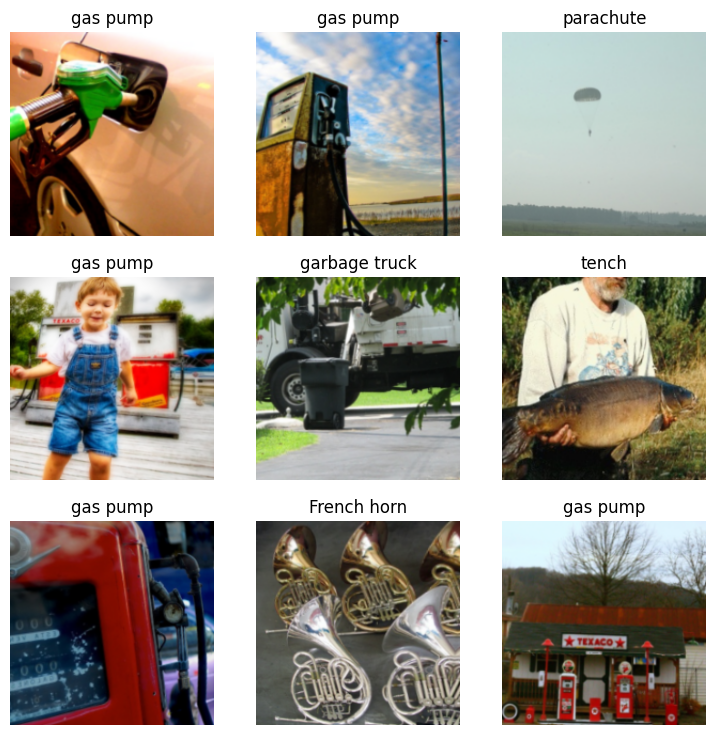

In [2]:
from fastai.vision.all import *

base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label",
    bs=16,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

dls.show_batch()

/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, m

SuggestedLRs(valley=0.0030199517495930195, slide=5.754399353463668e-06)

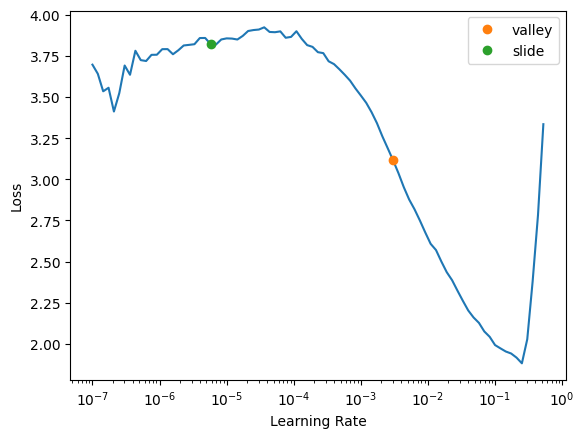

In [3]:
learn = vision_learner(dls, "convnext_small_in22k", metrics=accuracy).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

epoch,train_loss,valid_loss,accuracy,time
0,2.717296,0.258658,0.927273,00:02


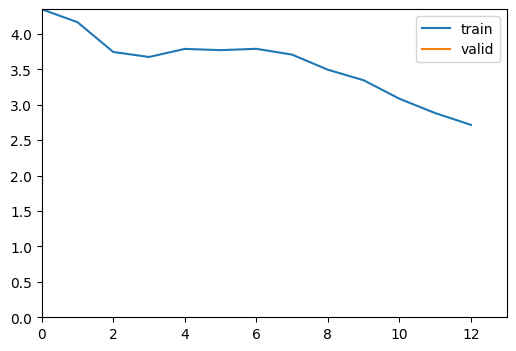

epoch,train_loss,valid_loss,accuracy,time
0,0.445454,0.044547,1.000000,00:02
1,0.323433,0.034167,1.000000,00:02
2,0.245538,0.032103,0.981818,00:02
3,0.172251,0.030835,1.000000,00:02
4,0.128581,0.031953,1.000000,00:02


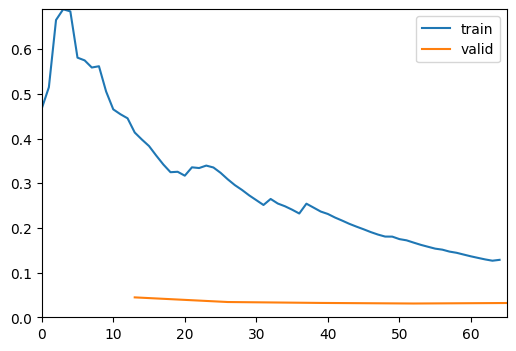

In [4]:
learn.fine_tune(5, base_lr=5e-3, freeze_epochs=1, cbs=ShowGraphCallback())


In [6]:
test_df = pd.read_parquet("evaluation_samples.parquet")
test_df

,filepath,label
0,data/imagenette/2/00000.jpg,cassette player
1,data/imagenette/2/00001.jpg,cassette player
2,data/imagenette/2/00002.jpg,cassette player
3,data/imagenette/2/00003.jpg,cassette player
4,data/imagenette/2/00004.jpg,cassette player
...,...,...
3920,data/imagenette/5/03920.jpg,French horn
3921,data/imagenette/5/03921.jpg,French horn
3922,data/imagenette/5/03922.jpg,French horn
3923,data/imagenette/5/03923.jpg,French horn


In [8]:
filepaths = test_df["filepath"].tolist()
labels = test_df["label"].tolist()
test_dl = dls.test_dl(filepaths, bs=16)
preds, _, cls_preds = learn.get_preds(dl=test_dl, with_decoded=True)

results = pd.DataFrame(
    {
        "filepath": filepaths,
        "label": labels,
        "pred_label": [learn.dls.vocab[i] for i in cls_preds.numpy()],
    }
)

accuracy = float((results["label"] == results["pred_label"]).mean())
accuracy


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


0.9933757961783439